### 1. Import libraries

In [2]:
import os
import random
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

import tensorflow as tf
print('tensorflow version' , tf.__version__)

import sys
sys.path.append("../script/")
import functions as fc
import Datagenerator as dg
import model as md

importlib.reload(fc)
importlib.reload(md)
importlib.reload(dg)

tensorflow version 2.10.0


<module 'Datagenerator' from 'c:\\Users\\Zacca\\OneDrive\\Desktop\\ociap8-test_func\\notebook\\../script\\Datagenerator.py'>

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### 2. Préparation données

#### 2.1 Import données

In [6]:
# Define the paths to the raw data and specific datasets
processed_data_path = "../data/processed/res_data"
if os.path.exists(processed_data_path):
    raw_data_path = processed_data_path
    print("Using processed images from ../data/processed/res_data")
else:
    raw_data_path = "../data/raw"
    print("Using raw images from ../data/raw")

leftImg8bit_path = os.path.join(raw_data_path, "leftImg8bit/")
gtFine_path = os.path.join(raw_data_path, "gtFine/")

Using processed images from ../data/processed/res_data


#### 2.2 Définition des paramètres

In [7]:
# Définir dimensions images
DIM_X = 256
DIM_Y = 256
INPUT_SHAPE = (DIM_X, DIM_Y, 3)
# définition class de sortie
N_CLASS = 8

### 3. Préparation des données

#### 3.1 Récuperer les chemins d'accès aux images et prépartion echantillon de test

In [8]:
# Listes des chemins des images
x_train_path, x_test_path, x_val_path = fc.getPathFiles(leftImg8bit_path)
# Listes des chemins des masques
y_train_path, y_test_path, y_val_path = fc.getPathFiles(gtFine_path, "labelIds.png")

# Echantillon préparé pour les tests
X_test, y_test = fc.get_data_prepared(
    x_test_path[0:10], y_test_path[0:10], (DIM_X, DIM_Y)
)

#### 3.2 Redimensionnement des images

In [9]:
data_redim_path = "../data/processed/res_data"

# Check if the directory already exists
if not os.path.exists(data_redim_path):
    os.mkdir(data_redim_path)

    # Iterate over the directories in 'data/raw'
    for dir_1 in os.listdir("../data/raw"):
        if (
            dir_1 != "img"
            and dir_1 != ".DS_Store"
            and os.path.isdir(os.path.join("../data/raw", dir_1))
        ):
            os.mkdir(os.path.join(data_redim_path, dir_1))
            for dir_2 in os.listdir(os.path.join("../data/raw", dir_1)):
                if dir_2 != ".DS_Store":
                    os.mkdir(os.path.join(data_redim_path, dir_1, dir_2))
                    for dir_3 in os.listdir(os.path.join("../data/raw", dir_1, dir_2)):
                        if dir_3 != ".DS_Store":
                            os.mkdir(os.path.join(data_redim_path, dir_1, dir_2, dir_3))

    all_images_path = (
        x_train_path
        + x_test_path
        + x_val_path
        + y_train_path
        + y_test_path
        + y_val_path
    )

    print(f"Number of images to process: {len(all_images_path)}")

    # Resize and save the images in the new directory
    for path in all_images_path:
        if ".DS_Store" not in path:
            img = cv2.imread(path)
            if img is None:
                print(f"Failed to read image at {path}")
                continue
            img = cv2.resize(img, (1024, 512))
            new_path = path.replace(raw_data_path, "../data/processed/res_data")
            cv2.imwrite(new_path, img)
            print(f"Saved resized image to {new_path}")

else:
    print(f"Dossier {data_redim_path} existe déjà")

Dossier ../data/processed/res_data existe déjà


#### 3.3 Data Augmentation 

In [10]:
# Sort the lists of paths
x_train_path.sort()
y_train_path.sort()

# Load and resize the first 5 training images from the paths specified in x_train_path.
X = np.array(
    [
        cv2.resize(cv2.imread(path_X), (DIM_X, DIM_Y))
        for path_X in x_train_path
        if not path_X.endswith(".DS_Store")
    ][0:3]
)

# Load, convert to mask, and resize the first 5 training mask images from the paths specified in y_train_path.
y = np.array(
    [
        cv2.resize(fc.convert_mask(cv2.imread(path_y, 0)), (DIM_X, DIM_Y))
        for path_y in y_train_path
        if not path_y.endswith(".DS_Store")
    ][0:3]
)

# Augment the training data and mask.
X_augmented, y_augmented = fc.augment_data(X, y)

# Convert the augmented masks into a form where each pixel is the index of the class it belongs to.
y_augmented_arg = np.argmax(y_augmented, axis=3)

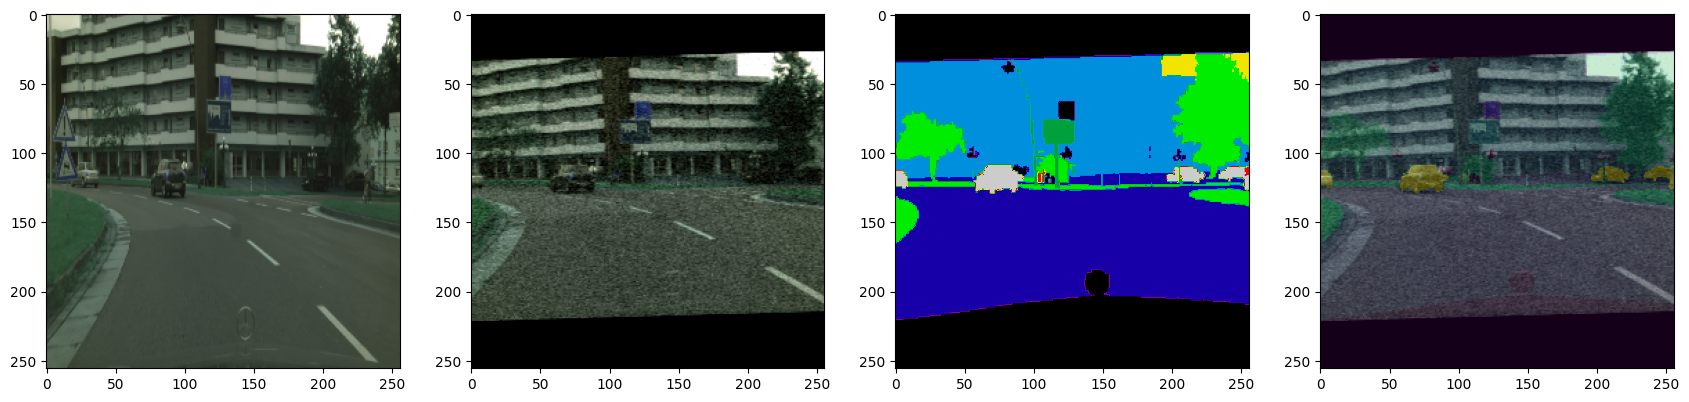

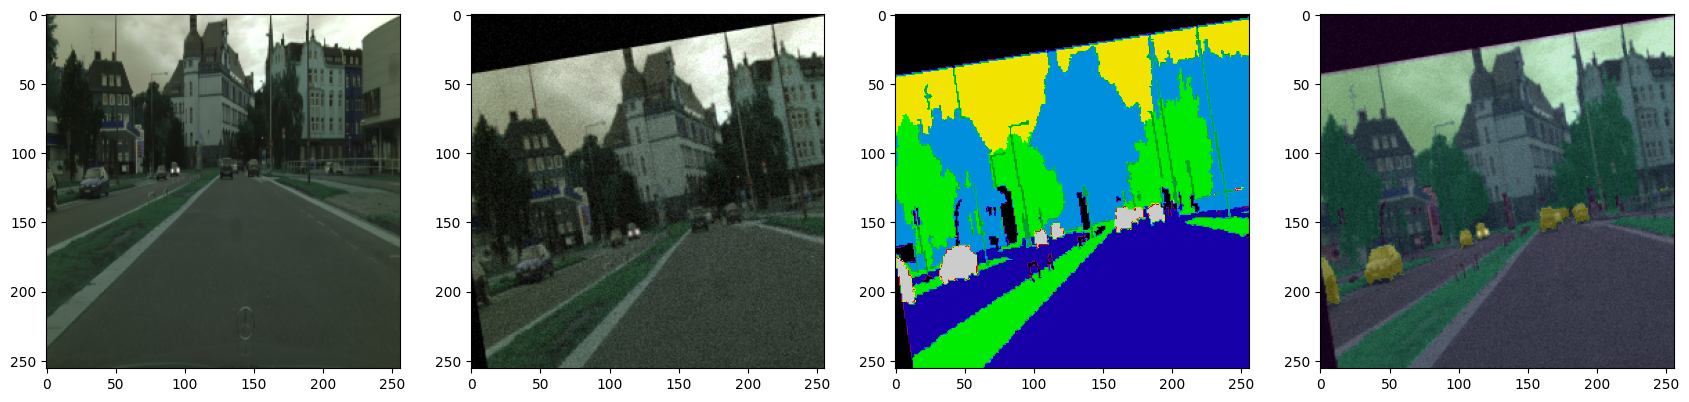

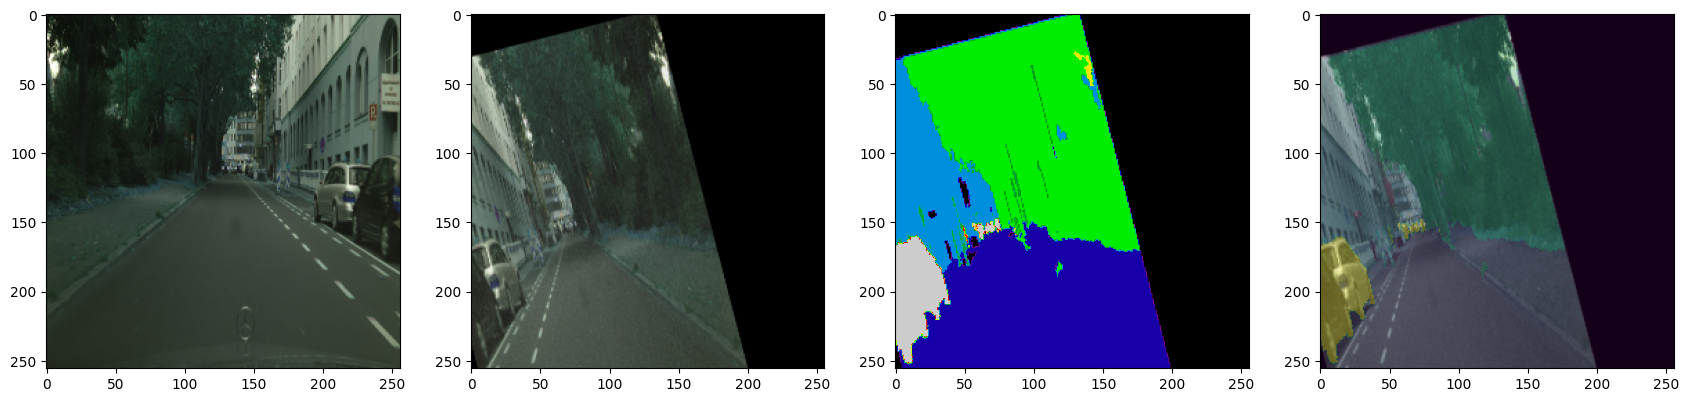

In [11]:
for i in range(len(X)):
    plt.subplots(1, 4, figsize=(21, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(X[i])

    plt.subplot(1, 4, 2)
    plt.imshow(X_augmented[i])

    plt.subplot(1, 4, 3)
    plt.imshow(y_augmented_arg[i], cmap="nipy_spectral")

    plt.subplot(1, 4, 4)
    plt.imshow(X_augmented[i])
    plt.imshow(y_augmented_arg[i], alpha=0.3)

    plt.show()

#### 3.3 Data Generator

In [12]:
# Création d'un DataGenerator pour les données d'entraînement sans augmentation des données.
data_train = dg.DataGenerator(
    x_train_path, y_train_path, batch_size=20, dim=(DIM_X, DIM_Y), augmentation=False
)

# Création d'un DataGenerator pour les données de validation sans augmentation des données.
data_val = dg.DataGenerator(
    x_val_path, y_val_path, batch_size=20, dim=(DIM_X, DIM_Y), augmentation=False
)

# Création d'un DataGenerator pour les données d'entraînement avec augmentation des données.
data_train_augmented = dg.DataGenerator(
    x_train_path, y_train_path, batch_size=10, dim=(DIM_X, DIM_Y), augmentation=True
)

# Création d'un DataGenerator pour les données de validation avec augmentation des données.
data_val_augmented = dg.DataGenerator(
    x_val_path, y_val_path, batch_size=10, dim=(DIM_X, DIM_Y), augmentation=True
)

### 4.4 Modélisation

### Mini U-net

In [15]:
# Build model
model = md.build_mini_unet(INPUT_SHAPE, N_CLASS)
model_name = model.name + "_basic"
model.summary()

Model: "Mini_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 256, 256, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 256, 256, 32  128        ['conv2d_6[0][0]']               
 rmalization)                   )                                                        

In [16]:
# Train model
print(f"Modèle : {model_name}")
model, hist_df, training_time = fc.train_model(
    model,
    model_name,
    data_train,
    data_train_augmented,
    data_val_augmented,
    data_val,
    X_test,
    "categorical_crossentropy",
    False,
)

Modèle : Mini_U-Net_basic
Epoch 1/15
148/148 [==============================] - 66s 434ms/step - loss: 2.1462 - mean_iou: 0.0721 - val_loss: 2.0876 - val_mean_iou: 0.0758
Epoch 2/15
148/148 [==============================] - 69s 463ms/step - loss: 2.0222 - mean_iou: 0.1049 - val_loss: 2.0223 - val_mean_iou: 0.0911
Epoch 3/15
148/148 [==============================] - 66s 440ms/step - loss: 1.9342 - mean_iou: 0.1031 - val_loss: 1.9399 - val_mean_iou: 0.0953
Epoch 4/15
148/148 [==============================] - 68s 458ms/step - loss: 1.8623 - mean_iou: 0.1022 - val_loss: 1.8709 - val_mean_iou: 0.0962
Epoch 5/15
148/148 [==============================] - 67s 451ms/step - loss: 1.8157 - mean_iou: 0.1021 - val_loss: 1.8298 - val_mean_iou: 0.0993
Epoch 6/15
148/148 [==============================] - 71s 477ms/step - loss: 1.7807 - mean_iou: 0.1039 - val_loss: 1.7941 - val_mean_iou: 0.1009
Epoch 7/15
148/148 [==============================] - 70s 466ms/step - loss: 1.7552 - mean_iou: 0.1062 -

INFO:tensorflow:Assets written to: ../model/checkpoint/Mini_U-Net_basic\assets


INFO:tensorflow:Assets written to: ../model/checkpoint/Mini_U-Net_basic\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmp5l0irqdf\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmp5l0irqdf\assets


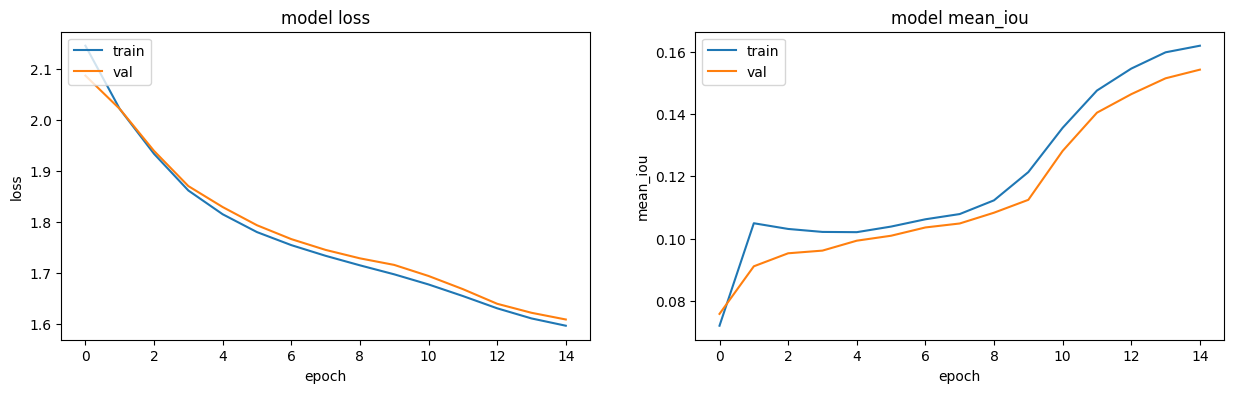

In [17]:
# Draw loss function and metric evolution
fc.draw_history(hist_df)

In [18]:
# Predict from model trained
y_pred_argmax = fc.predict_model(
    model,
    model_name,
    X_test,
    data_val,
    "categorical_crossentropy",
    training_time,
    show_pred=False,
)

25/25 [==============================] - 17s 674ms/step - loss: 1.6093 - mean_iou: 0.1542
Pour le meilleur modèle on obtient :
mean_iou : 0.15424782037734985
loss : 1.6093400716781616
1/1 [==============================] - 0s 371ms/step


#### Mini U-net, fonction dice loss

In [19]:
# Build model
model = md.build_mini_unet(INPUT_SHAPE, N_CLASS)
model_name = model.name + "_dice_loss"

In [20]:
# Train model
print(f"Modèle : {model_name}")
model, hist_df, training_time = fc.train_model(
    model,
    model_name,
    data_train,
    data_train_augmented,
    data_val_augmented,
    data_val,
    X_test,
    fc.dice_loss,
    False,
)

Modèle : Mini_U-Net_dice_loss
Epoch 1/15
148/148 [==============================] - 62s 407ms/step - loss: 0.8608 - mean_iou: 0.0542 - val_loss: 0.8678 - val_mean_iou: 0.0410
Epoch 2/15
148/148 [==============================] - 62s 414ms/step - loss: 0.8302 - mean_iou: 0.0864 - val_loss: 0.8453 - val_mean_iou: 0.0828
Epoch 3/15
148/148 [==============================] - 64s 431ms/step - loss: 0.7950 - mean_iou: 0.0970 - val_loss: 0.8073 - val_mean_iou: 0.0946
Epoch 4/15
148/148 [==============================] - 65s 437ms/step - loss: 0.7655 - mean_iou: 0.1059 - val_loss: 0.7551 - val_mean_iou: 0.0985
Epoch 5/15
148/148 [==============================] - 63s 419ms/step - loss: 0.7441 - mean_iou: 0.1153 - val_loss: 0.7155 - val_mean_iou: 0.1080
Epoch 6/15
148/148 [==============================] - 64s 428ms/step - loss: 0.7275 - mean_iou: 0.1190 - val_loss: 0.6851 - val_mean_iou: 0.1123
Epoch 7/15
148/148 [==============================] - 62s 416ms/step - loss: 0.7119 - mean_iou: 0.12

INFO:tensorflow:Assets written to: ../model/checkpoint/Mini_U-Net_dice_loss\assets


INFO:tensorflow:Assets written to: ../model/checkpoint/Mini_U-Net_dice_loss\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpuonoawyw\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpuonoawyw\assets


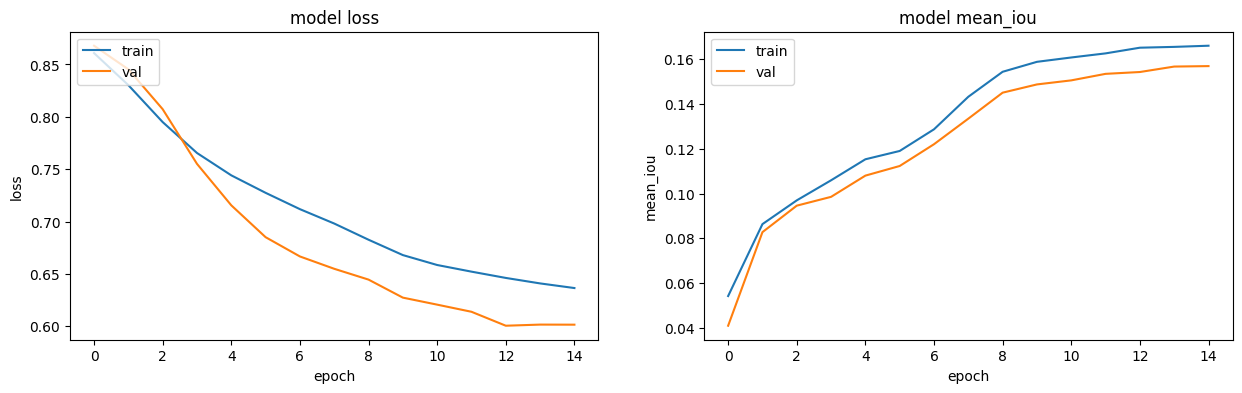

In [21]:
# Draw loss function and metric evolution
fc.draw_history(hist_df)

In [23]:
# Predict from model trained
y_pred_argmax = fc.predict_model(
    model,
    model_name,
    X_test,
    data_val,
    fc.dice_loss,
    training_time,
    show_pred=False,
)

25/25 [==============================] - 17s 651ms/step - loss: 0.6016 - mean_iou: 0.1570
Pour le meilleur modèle on obtient :
mean_iou : 0.15695297718048096
loss : 0.60163414478302
1/1 [==============================] - 0s 98ms/step


#### Model Mini U-Net Total Loss

In [24]:
# Build model
model = md.build_mini_unet(INPUT_SHAPE, N_CLASS)
model_name = model.name + "_total_loss"

In [25]:
# Train model
print(f"Modèle : {model_name}")
model, hist_df, training_time = fc.train_model(
    model,
    model_name,
    data_train,
    data_train_augmented,
    data_val_augmented,
    data_val,
    X_test,
    fc.total_loss,
    False,
)

Modèle : Mini_U-Net_total_loss
Epoch 1/15
148/148 [==============================] - 63s 415ms/step - loss: 4.8838 - mean_iou: 0.0427 - val_loss: 4.7310 - val_mean_iou: 0.0663
Epoch 2/15
148/148 [==============================] - 60s 404ms/step - loss: 4.6807 - mean_iou: 0.0876 - val_loss: 4.6657 - val_mean_iou: 0.0887
Epoch 3/15
148/148 [==============================] - 61s 411ms/step - loss: 4.5915 - mean_iou: 0.1000 - val_loss: 4.5938 - val_mean_iou: 0.0985
Epoch 4/15
148/148 [==============================] - 60s 401ms/step - loss: 4.5184 - mean_iou: 0.1020 - val_loss: 4.5183 - val_mean_iou: 0.1006
Epoch 5/15
148/148 [==============================] - 60s 402ms/step - loss: 4.4514 - mean_iou: 0.1022 - val_loss: 4.4489 - val_mean_iou: 0.1012
Epoch 6/15
148/148 [==============================] - 59s 399ms/step - loss: 4.3754 - mean_iou: 0.1050 - val_loss: 4.3671 - val_mean_iou: 0.1023
Epoch 7/15
148/148 [==============================] - 59s 399ms/step - loss: 4.3050 - mean_iou: 0.1

INFO:tensorflow:Assets written to: ../model/checkpoint/Mini_U-Net_total_loss\assets


INFO:tensorflow:Assets written to: ../model/checkpoint/Mini_U-Net_total_loss\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpfly9qkot\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpfly9qkot\assets


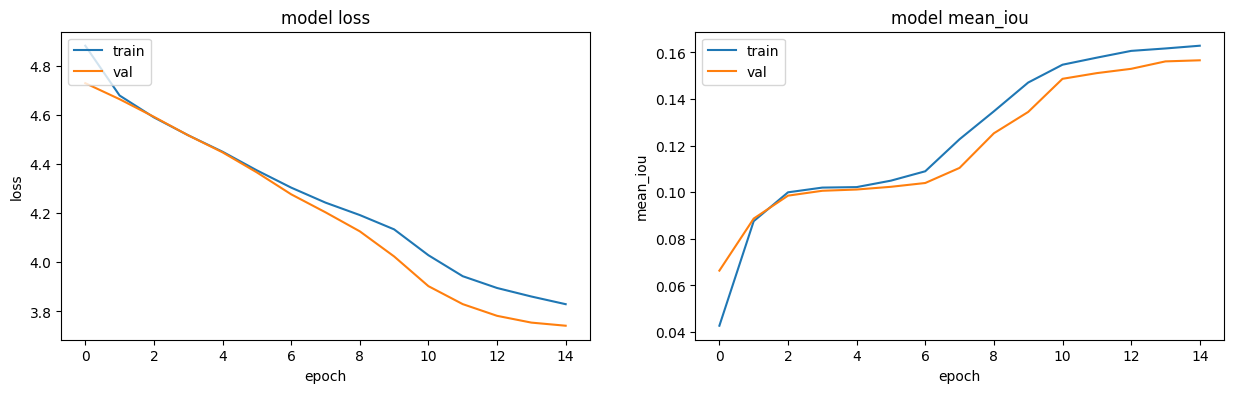

In [26]:
# Draw loss function and metric evolution
fc.draw_history(hist_df)

In [27]:
# Predict from model trained
y_pred_argmax = fc.predict_model(
    model,
    model_name,
    X_test,
    data_val,
    fc.total_loss,
    training_time,
    show_pred=False,
)

25/25 [==============================] - 16s 625ms/step - loss: 3.7416 - mean_iou: 0.1566
Pour le meilleur modèle on obtient :
mean_iou : 0.1566384881734848
loss : 3.741635322570801
1/1 [==============================] - 0s 89ms/step


### Modèle Mini Unet data augmented

In [28]:
# Build model
model = md.build_mini_unet(INPUT_SHAPE, N_CLASS)
model_name = model.name + "_augmentation"

In [29]:
# Train model
print(f"Modèle : {model_name}")
model, hist_df, training_time = fc.train_model(
    model,
    model_name,
    data_train,
    data_train_augmented,
    data_val_augmented,
    data_val,
    X_test,
    fc.total_loss,
    True,
)

Modèle : Mini_U-Net_augmentation
Epoch 1/15
297/297 [==============================] - 79s 261ms/step - loss: 4.6119 - mean_iou: 0.0420 - val_loss: 4.5069 - val_mean_iou: 0.0453
Epoch 2/15
297/297 [==============================] - 78s 260ms/step - loss: 4.4554 - mean_iou: 0.0712 - val_loss: 4.4585 - val_mean_iou: 0.0736
Epoch 3/15
297/297 [==============================] - 77s 258ms/step - loss: 4.3767 - mean_iou: 0.0827 - val_loss: 4.3685 - val_mean_iou: 0.0797
Epoch 4/15
297/297 [==============================] - 78s 260ms/step - loss: 4.2967 - mean_iou: 0.0907 - val_loss: 4.2864 - val_mean_iou: 0.0867
Epoch 5/15
297/297 [==============================] - 77s 257ms/step - loss: 4.2457 - mean_iou: 0.0992 - val_loss: 4.2153 - val_mean_iou: 0.1000
Epoch 6/15
297/297 [==============================] - 78s 260ms/step - loss: 4.1973 - mean_iou: 0.1053 - val_loss: 4.1579 - val_mean_iou: 0.1006
Epoch 7/15
297/297 [==============================] - 79s 266ms/step - loss: 4.1605 - mean_iou: 0

INFO:tensorflow:Assets written to: ../model/checkpoint/Mini_U-Net_augmentation\assets


INFO:tensorflow:Assets written to: ../model/checkpoint/Mini_U-Net_augmentation\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpif6woa4j\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpif6woa4j\assets


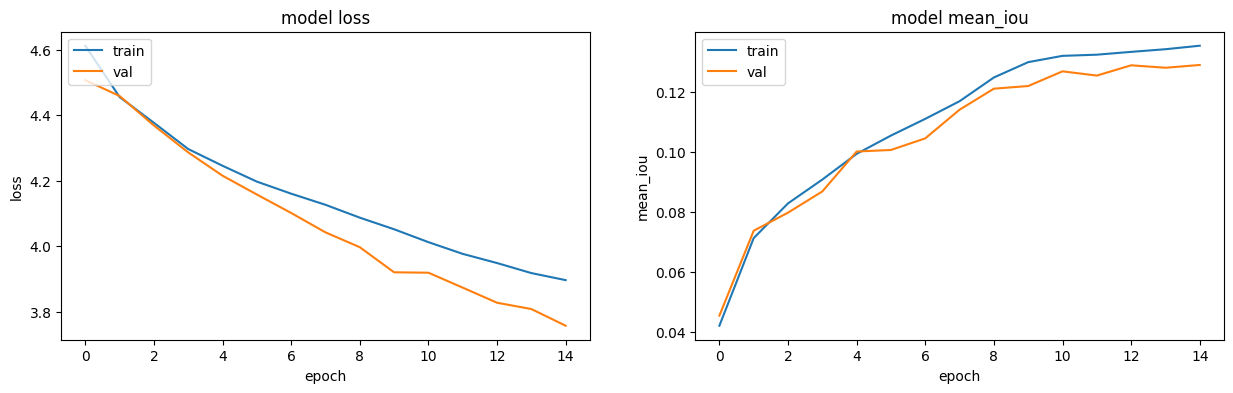

In [30]:
# Draw loss function and metric evolution
fc.draw_history(hist_df)

In [31]:
# Predict from model trained
y_pred_argmax = fc.predict_model(
    model,
    model_name,
    X_test,
    data_val,
    "total_loss",
    training_time,
    show_pred=False,
)

25/25 [==============================] - 16s 613ms/step - loss: 3.8020 - mean_iou: 0.1615
Pour le meilleur modèle on obtient :
mean_iou : 0.16149748861789703
loss : 3.802046775817871
1/1 [==============================] - 0s 84ms/step


### Modèles Resnet50 Unet

In [32]:
# Build model
model = md.build_resnet50(INPUT_SHAPE, N_CLASS)
model_name = model.name + "_basic"

In [33]:
# Train model
print(f"Modèle : {model_name}")
model, hist_df, training_time = fc.train_model(
    model,
    model_name,
    data_train,
    data_train_augmented,
    data_val_augmented,
    data_val,
    X_test,
    fc.total_loss,
    False,
)

Modèle : ResNet50_U-Net_basic
Epoch 1/15
148/148 [==============================] - 71s 416ms/step - loss: 4.0331 - mean_iou: 0.1622 - val_loss: 3.9501 - val_mean_iou: 0.1653
Epoch 2/15
148/148 [==============================] - 63s 423ms/step - loss: 2.8187 - mean_iou: 0.2473 - val_loss: 2.8364 - val_mean_iou: 0.2080
Epoch 3/15
148/148 [==============================] - 62s 418ms/step - loss: 2.5585 - mean_iou: 0.2631 - val_loss: 2.7023 - val_mean_iou: 0.2205
Epoch 4/15
148/148 [==============================] - 63s 422ms/step - loss: 2.4304 - mean_iou: 0.2921 - val_loss: 2.7012 - val_mean_iou: 0.2267
Epoch 5/15
148/148 [==============================] - 63s 418ms/step - loss: 2.3244 - mean_iou: 0.3191 - val_loss: 2.6956 - val_mean_iou: 0.2295
Epoch 6/15
148/148 [==============================] - 63s 423ms/step - loss: 2.2425 - mean_iou: 0.3310 - val_loss: 2.6321 - val_mean_iou: 0.2419
Epoch 7/15
148/148 [==============================] - 62s 417ms/step - loss: 2.1752 - mean_iou: 0.34

INFO:tensorflow:Assets written to: ../model/checkpoint/ResNet50_U-Net_basic\assets


INFO:tensorflow:Assets written to: ../model/checkpoint/ResNet50_U-Net_basic\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpw8jfi1xt\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpw8jfi1xt\assets


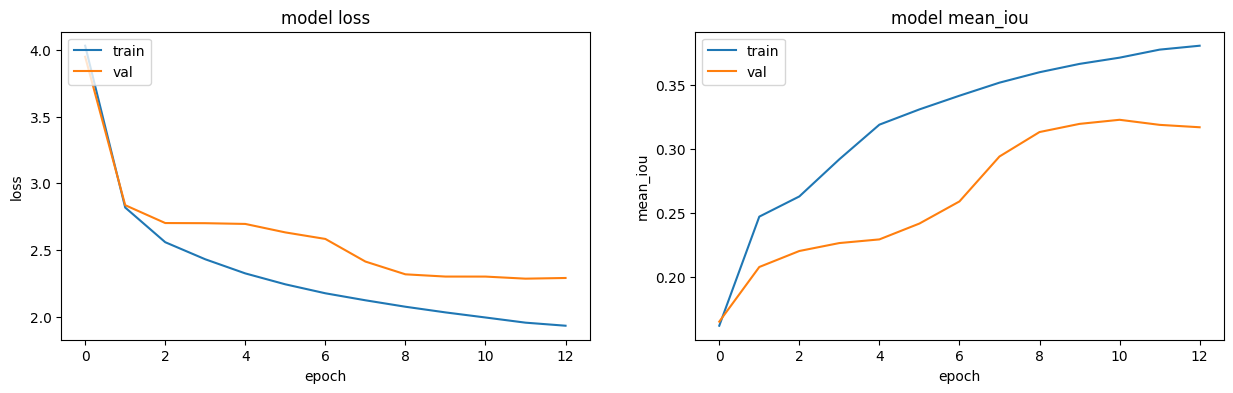

In [34]:
# Draw loss function and metric evolution
fc.draw_history(hist_df)

In [35]:
# Predict from model trained
y_pred_argmax = fc.predict_model(
    model,
    model_name,
    X_test,
    data_val,
    fc.total_loss,
    training_time,
    show_pred=False,
)

25/25 [==============================] - 17s 658ms/step - loss: 2.3005 - mean_iou: 0.3229
Pour le meilleur modèle on obtient :
mean_iou : 0.3229125738143921
loss : 2.3004753589630127


1/1 [==============================] - 1s 1s/step


### Modèle Vgg16 Unet

In [36]:
# Build model
model = md.build_vgg16_unet(INPUT_SHAPE, N_CLASS)
model_name = model.name + "_basic"

In [37]:
# Train model
print(f"Modèle : {model_name}")
model, hist_df, training_time = fc.train_model(
    model,
    model_name,
    data_train,
    data_train_augmented,
    data_val_augmented,
    data_val,
    X_test,
    fc.total_loss,
    False,
)

Modèle : VGG16_U-Net_basic
Epoch 1/15
148/148 [==============================] - 77s 449ms/step - loss: 4.4684 - mean_iou: 0.1456 - val_loss: 4.3051 - val_mean_iou: 0.1379
Epoch 2/15
148/148 [==============================] - 66s 442ms/step - loss: 3.0823 - mean_iou: 0.2564 - val_loss: 3.2299 - val_mean_iou: 0.2207
Epoch 3/15
148/148 [==============================] - 66s 442ms/step - loss: 2.6510 - mean_iou: 0.2727 - val_loss: 2.7854 - val_mean_iou: 0.2403
Epoch 4/15
148/148 [==============================] - 66s 442ms/step - loss: 2.5221 - mean_iou: 0.2774 - val_loss: 2.6360 - val_mean_iou: 0.2682
Epoch 5/15
148/148 [==============================] - 66s 442ms/step - loss: 2.4262 - mean_iou: 0.3023 - val_loss: 2.4776 - val_mean_iou: 0.2952
Epoch 6/15
148/148 [==============================] - 66s 438ms/step - loss: 2.3449 - mean_iou: 0.3155 - val_loss: 2.4008 - val_mean_iou: 0.2913
Epoch 7/15
148/148 [==============================] - 66s 442ms/step - loss: 2.2892 - mean_iou: 0.3218 

INFO:tensorflow:Assets written to: ../model/checkpoint/VGG16_U-Net_basic\assets


INFO:tensorflow:Assets written to: ../model/checkpoint/VGG16_U-Net_basic\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmp7vhok5dp\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmp7vhok5dp\assets


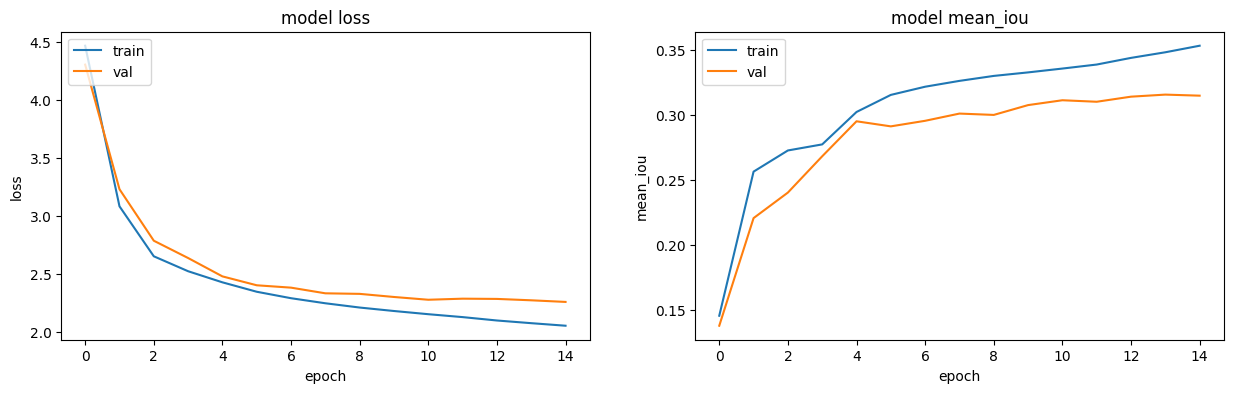

In [38]:
# Draw loss function and metric evolution
fc.draw_history(hist_df)

In [39]:
# Predict from model trained
y_pred_argmax = fc.predict_model(
    model,
    model_name,
    X_test,
    data_val,
    fc.total_loss,
    training_time,
    show_pred=False,
)

25/25 [==============================] - 20s 767ms/step - loss: 2.2712 - mean_iou: 0.3157
Pour le meilleur modèle on obtient :
mean_iou : 0.31567928194999695
loss : 2.271164655685425


1/1 [==============================] - 1s 1s/step


### Modèle Vgg16 avec augmentation des données

In [40]:
# Build model
model = md.build_vgg16_unet(INPUT_SHAPE, N_CLASS)
model_name = model.name + "_augmentation"

In [41]:
# Train model
print(f"Modèle : {model_name}")
model, hist_df, training_time = fc.train_model(
    model,
    model_name,
    data_train,
    data_train_augmented,
    data_val_augmented,
    data_val,
    X_test,
    fc.total_loss,
    True,
)

Modèle : VGG16_U-Net_augmentation
Epoch 1/15
297/297 [==============================] - 129s 427ms/step - loss: 3.6877 - mean_iou: 0.1432 - val_loss: 3.4547 - val_mean_iou: 0.1414
Epoch 2/15
297/297 [==============================] - 127s 425ms/step - loss: 2.8303 - mean_iou: 0.1873 - val_loss: 2.9579 - val_mean_iou: 0.1885
Epoch 3/15
297/297 [==============================] - 127s 424ms/step - loss: 2.7079 - mean_iou: 0.1957 - val_loss: 2.8334 - val_mean_iou: 0.2089
Epoch 4/15
297/297 [==============================] - 127s 427ms/step - loss: 2.6174 - mean_iou: 0.2162 - val_loss: 2.6741 - val_mean_iou: 0.2162
Epoch 5/15
297/297 [==============================] - 126s 423ms/step - loss: 2.5705 - mean_iou: 0.2224 - val_loss: 2.6140 - val_mean_iou: 0.2148
Epoch 6/15
297/297 [==============================] - 127s 425ms/step - loss: 2.5303 - mean_iou: 0.2310 - val_loss: 2.5745 - val_mean_iou: 0.2299
Epoch 7/15
297/297 [==============================] - 126s 423ms/step - loss: 2.5062 - mea

INFO:tensorflow:Assets written to: ../model/checkpoint/VGG16_U-Net_augmentation\assets


INFO:tensorflow:Assets written to: ../model/checkpoint/VGG16_U-Net_augmentation\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpfohziw9t\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpfohziw9t\assets


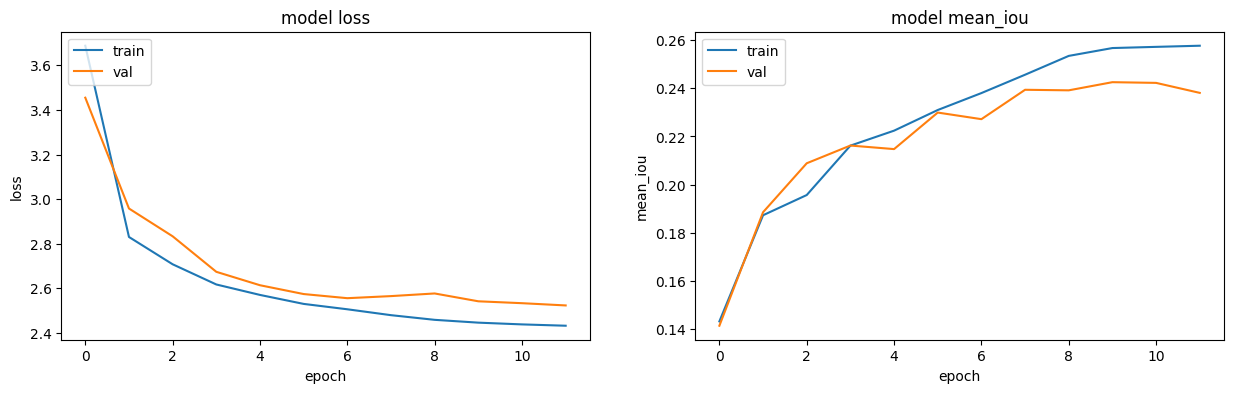

In [42]:
# Draw loss function and metric evolution
fc.draw_history(hist_df)

In [43]:
# Predict from model trained
y_pred_argmax = fc.predict_model(
    model,
    model_name,
    X_test,
    data_val,
    fc.total_loss,
    training_time,
    show_pred=False,
)

25/25 [==============================] - 18s 707ms/step - loss: 2.3385 - mean_iou: 0.3007
Pour le meilleur modèle on obtient :
mean_iou : 0.3006662428379059
loss : 2.3385262489318848
1/1 [==============================] - 0s 140ms/step


### Modèle Vgg19 avec augmentation des données

In [44]:
# Build model
model = md.build_vgg19_unet(INPUT_SHAPE, N_CLASS)
model_name = model.name + "_basic"

In [45]:
# Train model
print(f"Modèle : {model_name}")
model, hist_df, training_time = fc.train_model(
    model,
    model_name,
    data_train,
    data_train_augmented,
    data_val_augmented,
    data_val,
    X_test,
    fc.total_loss,
    False,
)

Modèle : VGG19_U-Net_basic
Epoch 1/15
148/148 [==============================] - 77s 503ms/step - loss: 4.1480 - mean_iou: 0.1552 - val_loss: 4.6282 - val_mean_iou: 0.0815
Epoch 2/15
148/148 [==============================] - 75s 502ms/step - loss: 2.8041 - mean_iou: 0.2438 - val_loss: 3.2060 - val_mean_iou: 0.2227
Epoch 3/15
148/148 [==============================] - 74s 495ms/step - loss: 2.4989 - mean_iou: 0.2553 - val_loss: 2.6900 - val_mean_iou: 0.2378
Epoch 4/15
148/148 [==============================] - 75s 500ms/step - loss: 2.3722 - mean_iou: 0.2806 - val_loss: 2.5143 - val_mean_iou: 0.2819
Epoch 5/15
148/148 [==============================] - 74s 497ms/step - loss: 2.2664 - mean_iou: 0.3069 - val_loss: 2.3622 - val_mean_iou: 0.2870
Epoch 6/15
148/148 [==============================] - 75s 499ms/step - loss: 2.2044 - mean_iou: 0.3181 - val_loss: 2.3142 - val_mean_iou: 0.3039
Epoch 7/15
148/148 [==============================] - 75s 499ms/step - loss: 2.1618 - mean_iou: 0.3254 

INFO:tensorflow:Assets written to: ../model/checkpoint/VGG19_U-Net_basic\assets


INFO:tensorflow:Assets written to: ../model/checkpoint/VGG19_U-Net_basic\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpvn2zzviy\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpvn2zzviy\assets


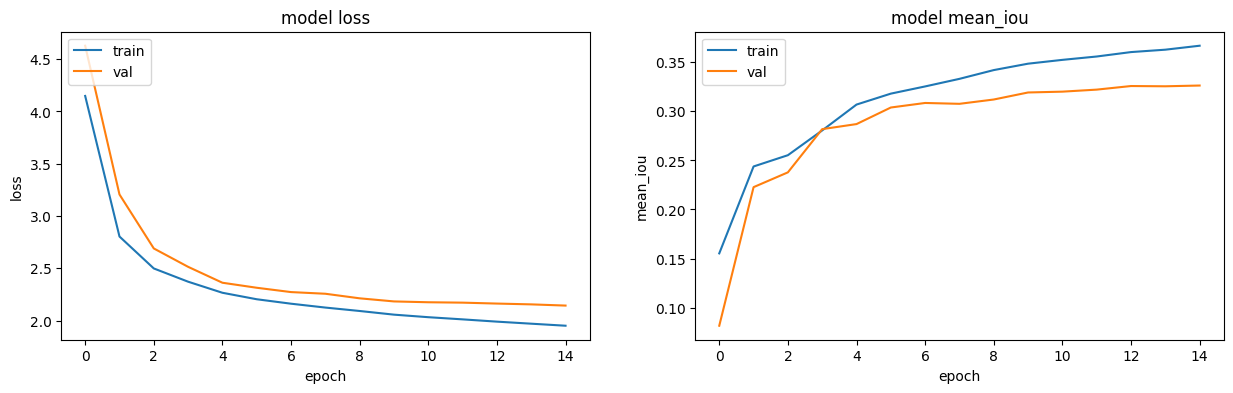

In [46]:
# Draw loss function and metric evolution
fc.draw_history(hist_df)

In [47]:
# Predict from model trained
y_pred_argmax = fc.predict_model(
    model,
    model_name,
    X_test,
    data_val,
    fc.total_loss,
    training_time,
    show_pred=False,
)

25/25 [==============================] - 18s 707ms/step - loss: 2.1439 - mean_iou: 0.3263
Pour le meilleur modèle on obtient :
mean_iou : 0.3263245224952698
loss : 2.1438724994659424
1/1 [==============================] - 0s 153ms/step


### Comparaison des modèles

In [3]:
df = fc.load_model_histories("../model/history/","../model/checkpoint/")

In [5]:
# Sort the DataFrame by 'mean_iou' in descending order
df_sorted = df.sort_values('mean_iou', ascending=False)

# Drop duplicates based on 'model_name', keep the first occurrence (the best one)
df_unique = df_sorted.drop_duplicates(subset='model_name', keep='first')

# Get the top 5 rows and reset the index
top_8_unique = df_unique.head(8).reset_index(drop=True)

# Define a new column order with 'model_name' as the first column
column_order = ['model_name'] + [col for col in top_8_unique.columns if col != 'model_name']

# Reorder the columns
top_8_unique = top_8_unique[column_order]

top_8_unique

,model_name,loss,mean_iou,val_loss,val_mean_iou,train_time
0,ResNet50_U-Net_basic,1.931723,0.380727,2.289996,0.317078,0h 14m 17s
1,VGG19_U-Net_basic,1.951304,0.366902,2.143868,0.326325,0h 18m 51s
2,VGG16_U-Net_basic,2.051760,0.353286,2.257199,0.314865,0h 16m 54s
3,VGG16_U-Net_augmentation,2.432474,0.257708,2.523420,0.238119,0h 25m 31s
4,Mini_U-Net_dice_loss,0.636590,0.166060,0.601636,0.156953,0h 15m 41s
5,Mini_U-Net_total_loss,3.829492,0.162899,3.741637,0.156638,0h 15m 0s
6,Mini_U-Net_basic,1.597114,0.161930,1.609340,0.154248,0h 16m 47s
7,Mini_U-Net_augmentation,3.896711,0.135285,3.757620,0.128868,0h 19m 21s
